# Tree, hyperparamètres, overfitting

L'[overfitting](https://en.wikipedia.org/wiki/Overfitting) ou [surapprentissage](https://fr.wikipedia.org/wiki/Surapprentissage) apparaît lorsque les prédictions sur de nouvelles données sont nettement moins bonnes que celles obtenus sur la base d'apprentissage. Les forêts aléatoires sont moins sujettes à l'overfitting que les arbres de décisions qui les composent. Quelques illustrations.

In [1]:
%matplotlib inline

## Données générées

On génère un nuage de points $y_i = \sin(x_i) + \epsilon_i$.

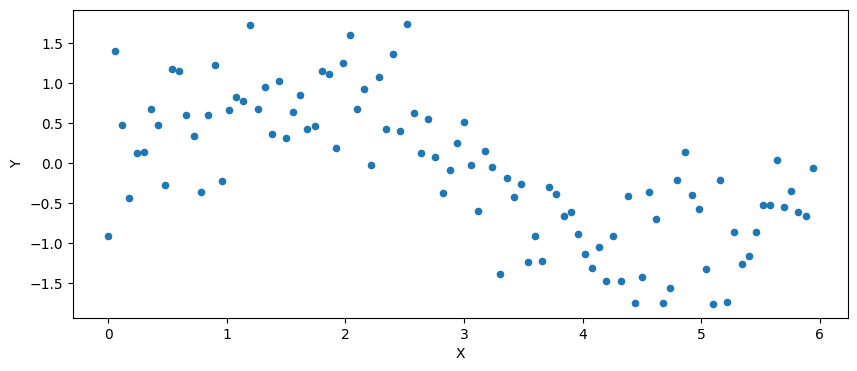

In [2]:
import math
import pandas
import numpy, numpy.random


def generate_data(n):
    import matplotlib.pyplot as plt

    X = numpy.arange(n) / n * 6
    mat = numpy.random.normal(size=(n, 1)) / 2
    si = numpy.sin(X).reshape((n, 1))
    Y = mat + si
    X = X.reshape((n, 1))
    data = numpy.hstack((X, Y))
    return data, X, Y


n = 100
data, X, Y = generate_data(n)
df = pandas.DataFrame(data, columns=["X", "Y"])
df.plot(x="X", y="Y", kind="scatter", figsize=(10, 4));

## Différents arbres de décision

On regarde l'influence de paramêtres sur la sortie du modèle résultant de son apprentissage.

### max_depth

Un arbre représente une fonction en escalier. La profondeur détermine le nombre de feuilles, c'est-à-dire le nombre de valeurs possibles : $2^{max\_depth}$.

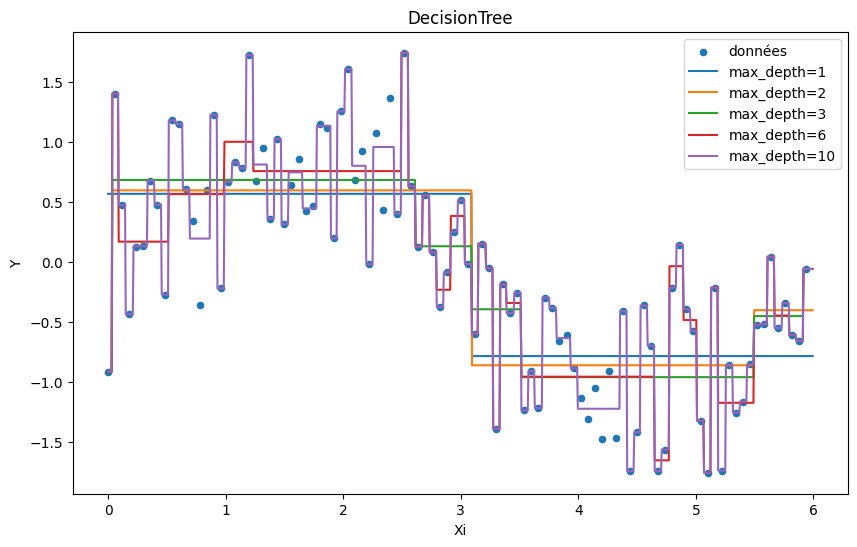

In [3]:
from sklearn.tree import DecisionTreeRegressor

ax = df.plot(
    x="X", y="Y", kind="scatter", figsize=(10, 6), label="données", title="DecisionTree"
)
Xi = (numpy.arange(n * 10) / n * 6 / 10).reshape((n * 10, 1))
for max_depth in [1, 2, 3, 6, 10]:
    clr = DecisionTreeRegressor(max_depth=max_depth)
    clr.fit(X, Y)
    pred = clr.predict(Xi)
    ex = pandas.DataFrame(Xi, columns=["Xi"])
    ex["pred"] = pred
    ex.sort_values("Xi").plot(
        x="Xi", y="pred", kind="line", label="max_depth=%d" % max_depth, ax=ax
    )

### min_samples_split=10

Chaque feuille d'un arbre prédit une valeur calculée à partir d'un ensemble d'observations. Ce nombre ne peut pas être inférieur à la valeur de ce paramètre. Ce mécanisme limite la possibilité de faire du surapprentissage en augmentant la représentativité de chaque feuille.

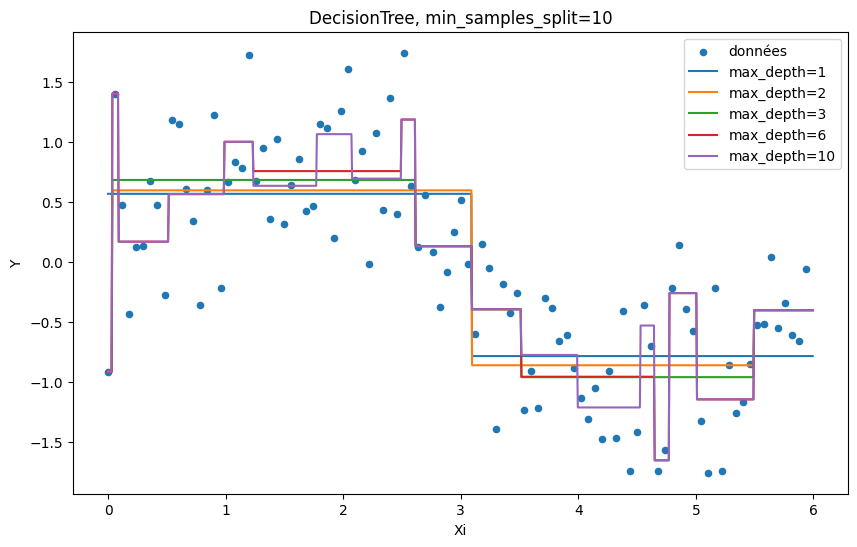

In [4]:
ax = df.plot(
    x="X",
    y="Y",
    kind="scatter",
    figsize=(10, 6),
    label="données",
    title="DecisionTree, min_samples_split=10",
)
Xi = (numpy.arange(n * 10) / n * 6 / 10).reshape((n * 10, 1))
for max_depth in [1, 2, 3, 6, 10]:
    clr = DecisionTreeRegressor(max_depth=max_depth, min_samples_split=10)
    clr.fit(X, Y)
    pred = clr.predict(Xi)
    ex = pandas.DataFrame(Xi, columns=["Xi"])
    ex["pred"] = pred
    ex.sort_values("Xi").plot(
        x="Xi", y="pred", kind="line", label="max_depth=%d" % max_depth, ax=ax
    )

## Random Forest

On étudie les deux mêmes paramètres pour une random forest à ceci près que ce modèle est une somme pondérée des résultats produits par un ensemble d'arbres de décision.

### max_depth

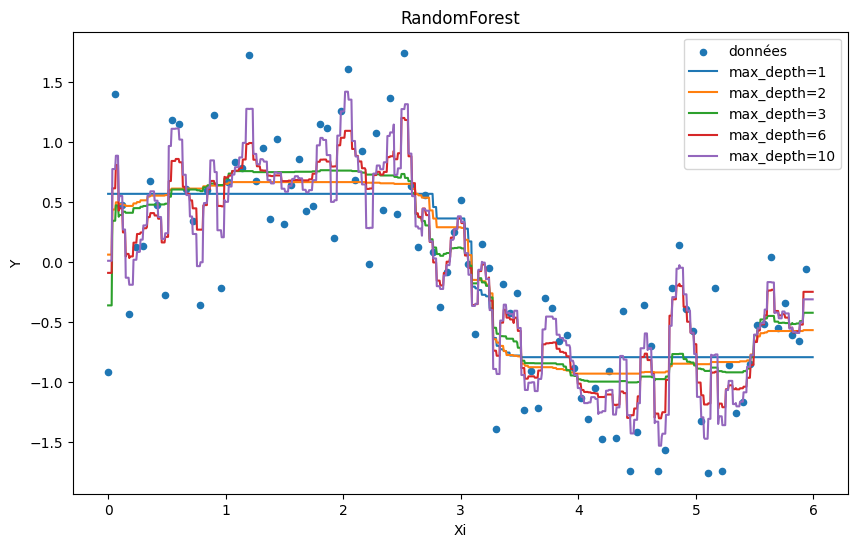

In [5]:
from sklearn.ensemble import RandomForestRegressor

ax = df.plot(
    x="X", y="Y", kind="scatter", figsize=(10, 6), label="données", title="RandomForest"
)
Xi = (numpy.arange(n * 10) / n * 6 / 10).reshape((n * 10, 1))
for max_depth in [1, 2, 3, 6, 10]:
    clr = RandomForestRegressor(max_depth=max_depth)
    clr.fit(X, Y.ravel())
    pred = clr.predict(Xi)
    ex = pandas.DataFrame(Xi, columns=["Xi"])
    ex["pred"] = pred
    ex.sort_values("Xi").plot(
        x="Xi", y="pred", kind="line", label="max_depth=%d" % max_depth, ax=ax
    )

### n_estimators

*n_estimators* est le nombre d'itérations, c'est extactement le nombre d'arbres de décisions qui feront partie de la forêt dans le cas d'une régression ou d'une classification binaire.

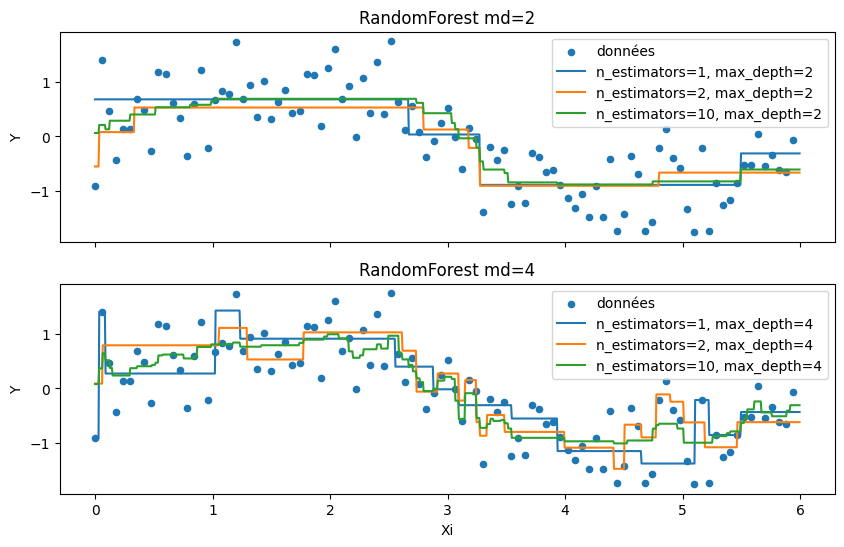

In [6]:
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

f, axarr = plt.subplots(2, sharex=True)
df.plot(
    x="X",
    y="Y",
    kind="scatter",
    figsize=(10, 6),
    label="données",
    title="RandomForest md=2",
    ax=axarr[0],
)
df.plot(
    x="X",
    y="Y",
    kind="scatter",
    figsize=(10, 6),
    label="données",
    title="RandomForest md=4",
    ax=axarr[1],
)
Xi = (numpy.arange(n * 10) / n * 6 / 10).reshape((n * 10, 1))
for i, max_depth in enumerate([2, 4]):
    for n_estimators in [1, 2, 10]:
        clr = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth)
        clr.fit(X, Y.ravel())
        pred = clr.predict(Xi)
        ex = pandas.DataFrame(Xi, columns=["Xi"])
        ex["pred"] = pred
        ex.sort_values("Xi").plot(
            x="Xi",
            y="pred",
            kind="line",
            label="n_estimators=%d, max_depth=%d" % (n_estimators, max_depth),
            ax=axarr[i],
        )

### min_samples_split=10

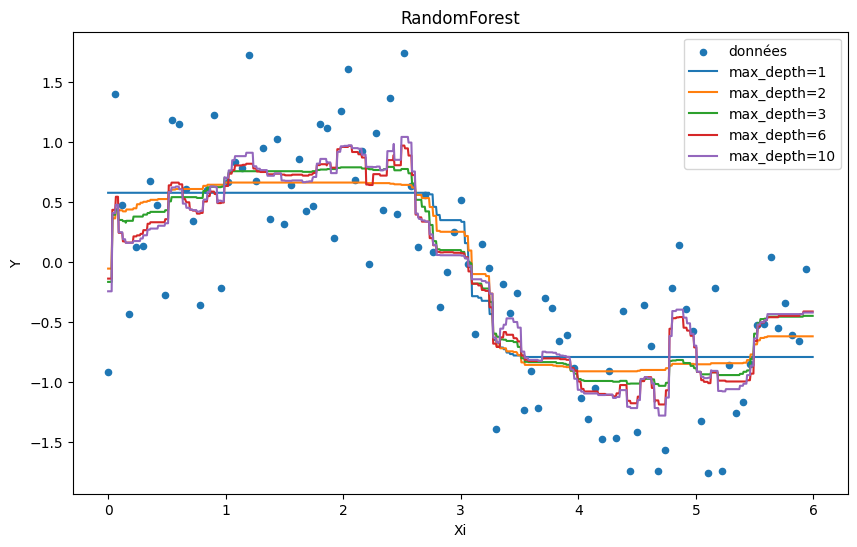

In [7]:
ax = df.plot(
    x="X", y="Y", kind="scatter", figsize=(10, 6), label="données", title="RandomForest"
)
Xi = (numpy.arange(n * 10) / n * 6 / 10).reshape((n * 10, 1))
for max_depth in [1, 2, 3, 6, 10]:
    clr = RandomForestRegressor(max_depth=max_depth, min_samples_split=10)
    clr.fit(X, Y.ravel())
    pred = clr.predict(Xi)
    ex = pandas.DataFrame(Xi, columns=["Xi"])
    ex["pred"] = pred
    ex.sort_values("Xi").plot(
        x="Xi", y="pred", kind="line", label="max_depth=%d" % max_depth, ax=ax
    )

## Base d'apprentissage et et base de test

C'est un des principes de base en machine learning : ne jamais tester un modèle sur les données d'apprentissage. Avec suffisamment de feuilles, un arbre de décision apprendra la valeur à prédire pour chaque observation. Le modèle apprend le bruit. Où s'arrête l'information, où commence le bruit, il n'est pas toujours évident de fixer le curseur.

### Decision Tree

In [8]:
data, X, Y = generate_data(1000)

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.33, random_state=42
)

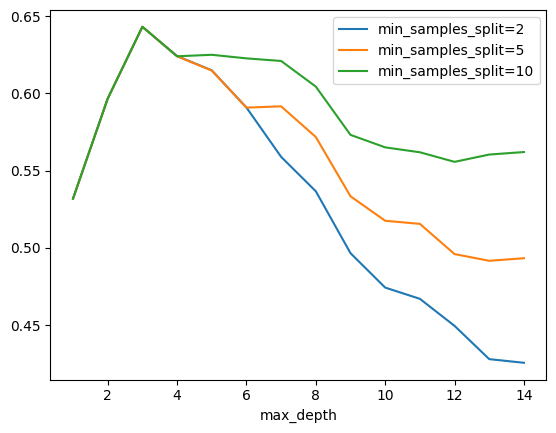

In [10]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score

min_samples_splits = [2, 5, 10]
rows = []
for max_depth in range(1, 15):
    d = dict(max_depth=max_depth)
    for min_samples_split in min_samples_splits:
        clr = DecisionTreeRegressor(
            max_depth=max_depth, min_samples_split=min_samples_split
        )
        clr.fit(X_train, y_train)
        pred = clr.predict(X_test)
        score = r2_score(y_test, pred)
        d["min_samples_split=%d" % min_samples_split] = score
    rows.append(d)
pandas.DataFrame(rows).plot(
    x="max_depth", y=["min_samples_split=%d" % _ for _ in min_samples_splits]
);

Le pic sur la base de test montre que passé un certain point, la performance décroît. A ce moment précis, le modèle commence à apprendre le bruit de la base d'apprentissage. Il overfitte. On remarque aussi que le modele overfitte moins lorsque *min_samples_split=10*.

### Random Forest

In [11]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score

rows = []
for n_estimators in range(1, 11):
    for max_depth in range(1, 11):
        for min_samples_split in [2, 5, 10]:
            clr = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth)
            clr.fit(X_train, y_train.ravel())
            pred = clr.predict(X_test)
            score = r2_score(y_test, pred)
            d = dict(max_depth=max_depth)
            d["n_estimators"] = n_estimators
            d["min_samples_split"] = min_samples_split
            d["score"] = score
            rows.append(d)
pl = pandas.DataFrame(rows)
pl.head()

max_depth  n_estimators  min_samples_split     score
0          1             1                  2  0.521566
1          1             1                  5  0.525835
2          1             1                 10  0.534421
3          2             1                  2  0.602039
4          2             1                  5  0.585866

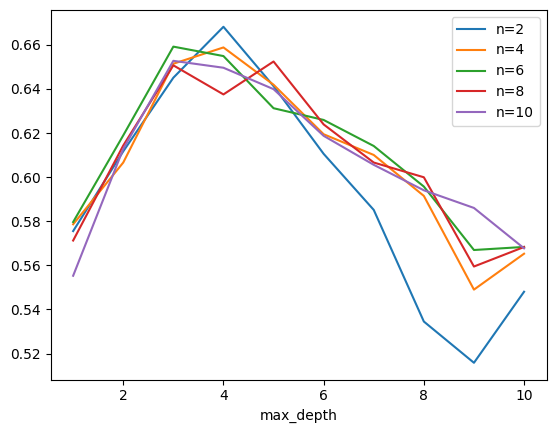

In [12]:
ax = pl[(pl.min_samples_split == 10) & (pl.n_estimators == 2)].plot(
    x="max_depth", y="score", label="n=2"
)
for i in (4, 6, 8, 10):
    pl[(pl.min_samples_split == 10) & (pl.n_estimators == i)].plot(
        x="max_depth", y="score", label="n=%d" % i, ax=ax
    )

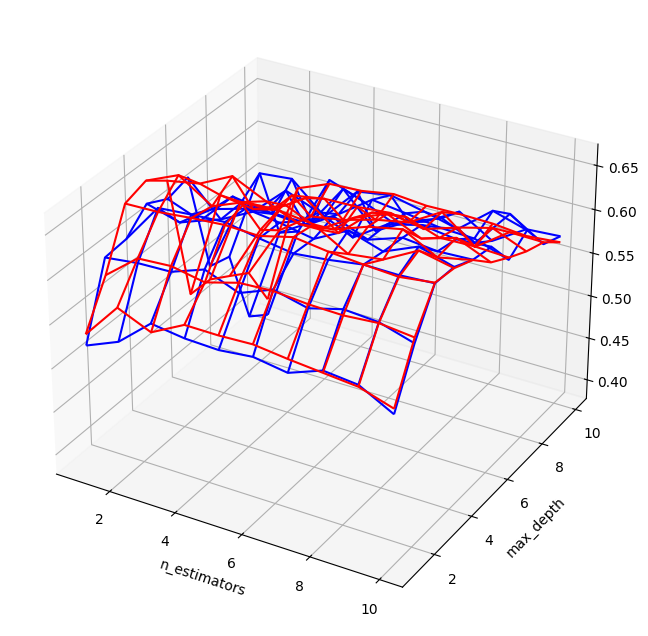

In [13]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="3d")
for v, c in [(2, "b"), (10, "r")]:
    piv = pl[pl.min_samples_split == v].pivot(
        index="n_estimators", columns="max_depth", values="score"
    )
    pivX = piv.copy()
    pivY = piv.copy()
    for v in piv.columns:
        pivX.loc[:, v] = piv.index
    for v in piv.index:
        pivY.loc[v, :] = piv.columns
    ax.plot_wireframe(pivX.values, pivY.values, piv.values, color=c)
ax.set_xlabel("n_estimators")
ax.set_ylabel("max_depth");

### Réseaux de neurones

Sur ce problème précis, les méthodes à base de gradient sont moins performantes. Elles paraissent également moins stables : la fonction d'erreur est plus agitée que celle obtenue pour les random forest. Ce type d'optimisation est plus sensible aux [extrema locaux](https://fr.wikiversity.org/wiki/Fonction_d%C3%A9riv%C3%A9e/Extremum_local).

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:03<00:09,  1.83s/it]/home/xadupre/install/scikit-learn/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
 43%|████▎     | 3/7 [00:07<00:10,  2.73s/it]/home/xadupre/install/scikit-learn/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
 57%|█████▋    | 4/7 [00:17<00:17,  5.89s/it]/home/xadupre/install/scikit-learn/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
 71%|███████▏  | 5/7 [00:24<00:12,  6.18s/it]/home/xadupre/install/scikit-learn/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iteration

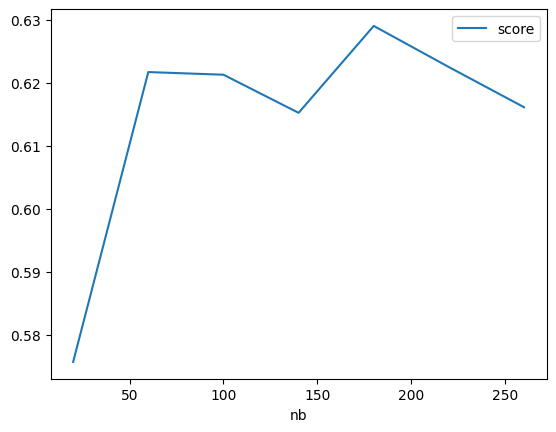

In [14]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score
from tqdm import tqdm

min_samples_splits = [2, 5, 10]
rows = []
for nb in tqdm(range(20, 300, 40)):
    clr = MLPRegressor(hidden_layer_sizes=(nb,), activation="relu", max_iter=200)
    clr.fit(X_train, y_train.ravel())
    pred = clr.predict(X_test)
    score = r2_score(y_test, pred)
    if score > 0:
        d = dict(nb=nb, score=score)
        rows.append(d)
pandas.DataFrame(rows).plot(x="nb", y=["score"]);

### Réseaux de neurones, alpha=0

  0%|          | 0/7 [00:00<?, ?it/s]/home/xadupre/install/scikit-learn/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
 14%|█▍        | 1/7 [00:00<00:02,  2.18it/s]/home/xadupre/install/scikit-learn/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
 29%|██▊       | 2/7 [00:02<00:06,  1.34s/it]/home/xadupre/install/scikit-learn/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
 43%|████▎     | 3/7 [00:06<00:11,  2.80s/it]/home/xadupre/install/scikit-learn/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) 

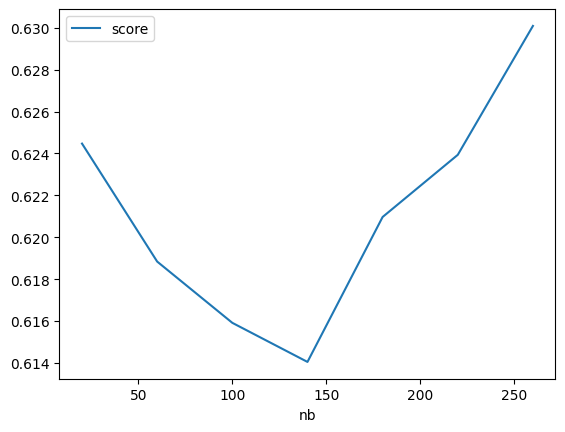

In [15]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score

min_samples_splits = [2, 5, 10]
rows = []
for nb in tqdm(range(20, 300, 40)):
    clr = MLPRegressor(
        hidden_layer_sizes=(nb,), activation="relu", alpha=0, tol=1e-6, max_iter=200
    )
    clr.fit(X_train, y_train.ravel())
    pred = clr.predict(X_test)
    score = r2_score(y_test, pred)
    if score > 0:
        d = dict(nb=nb, score=score)
        rows.append(d)
pandas.DataFrame(rows).plot(x="nb", y=["score"]);

## Exercice 1 : déterminer les paramètres optimaux pour cet exemple

A vérifier avec [grid_search](https://scikit-learn.org/stable/modules/grid_search.html), [hyperopt](https://github.com/hyperopt/hyperopt-sklearn), [model_selection](https://scikit-learn.org/stable/modules/model_selection.html).

## Exercice 2 : ajouter quelques points aberrants

## Intervalles de confiance

On pourrait utiliser le module [forest-confidence-interval](https://github.com/scikit-learn-contrib/forest-confidence-interval) mais il ne semble plus vraiment maintenu. Le module s'appuie sur le [Jackknife](https://en.wikipedia.org/wiki/Jackknife_resampling) pour estimer des intervalles de confiance. Il calcule un estimateur qui calcule une sortie en supprimant plusieurs fois un arbre lors de l'évaluation de la sortie de la forêt aléatoire. La théorie s'appuie sur un *resampling* de la base d'apprentissage que l'article considère comme équivalent à ceux effectués par scikit-learn pour générer chaque arbre. L'idée s'appuie sur l'article [Confidence Intervals for Random Forests: The Jackknife and the Infinitesimal Jackknife](http://jmlr.csail.mit.edu/papers/volume15/wager14a/wager14a.pdf).

## XGBoost

In [16]:
clr = RandomForestRegressor(n_estimators=10, max_depth=2)
clr.fit(X_train, y_train.ravel())

RandomForestRegressor(max_depth=2, n_estimators=10)

In [17]:
from xgboost import XGBRegressor

clrx = XGBRegressor(n_estimators=10, max_depth=2)
clrx.fit(X_train, y_train.ravel())

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=2, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=10, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

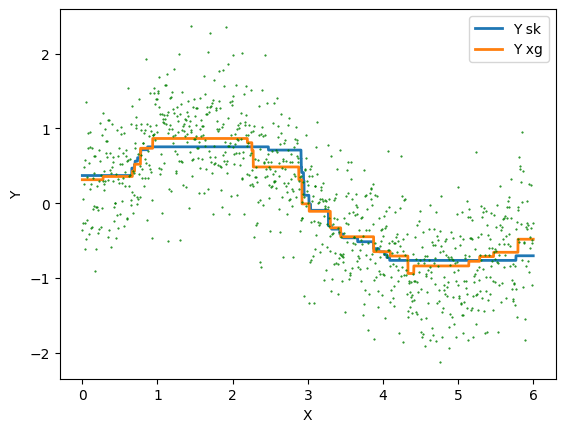

In [18]:
Xs = numpy.arange(start=0, stop=6, step=0.001)
Xs = Xs.reshape((len(Xs), 1))
ps = clr.predict(Xs)
ps = ps.reshape((len(ps), 1))
psx = clrx.predict(Xs)
psx = psx.reshape((len(psx), 1))

df = pandas.DataFrame(numpy.hstack((Xs, ps, psx)), columns=["X", "Y sk", "Y xg"])
ax = df.plot(x="X", y=["Y sk", "Y xg"], kind="line", lw=2)
ax.plot(X, Y, "g.", ms=1)
plt.xlabel("X")
plt.ylabel("Y");

## Exercice 3 : optimiser les hyperparamètres pour XGBoost et scikit-learn et comparer